<a href="https://colab.research.google.com/github/Dylan-Morrissey/Fat-Prediction-Neural-Network/blob/master/Bodyfat_Predicton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import random
import glob

In [0]:
print(tf.__version__)

2.1.0


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cols = ["Gender", "Age", "Weight", "Height", "Bodyfat"]
inputfile = "/content/gdrive/My Drive/Bodyfat Dataset/UsersInfo.txt"
df = pd.read_csv(inputfile, sep=" ", header=None, names=cols)
df.head()

,Gender,Age,Weight,Height,Bodyfat
0,M,23,222,195.58,10-12
1,M,24,161,170.18,10
2,M,22,180,177.80\t15,NaN
3,M,28,195,182.88\t9,NaN
4,M,22,172,172.72,16-19


In [0]:
images = []
inputPath = "/content/gdrive/My Drive/Bodyfat Dataset/"
from PIL import Image
import glob
import cv2
for file in glob.glob(inputPath+"*.jpg"):
  image = cv2.imread(file)
  image = cv2.resize(image,(200,200))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  images.append(image)

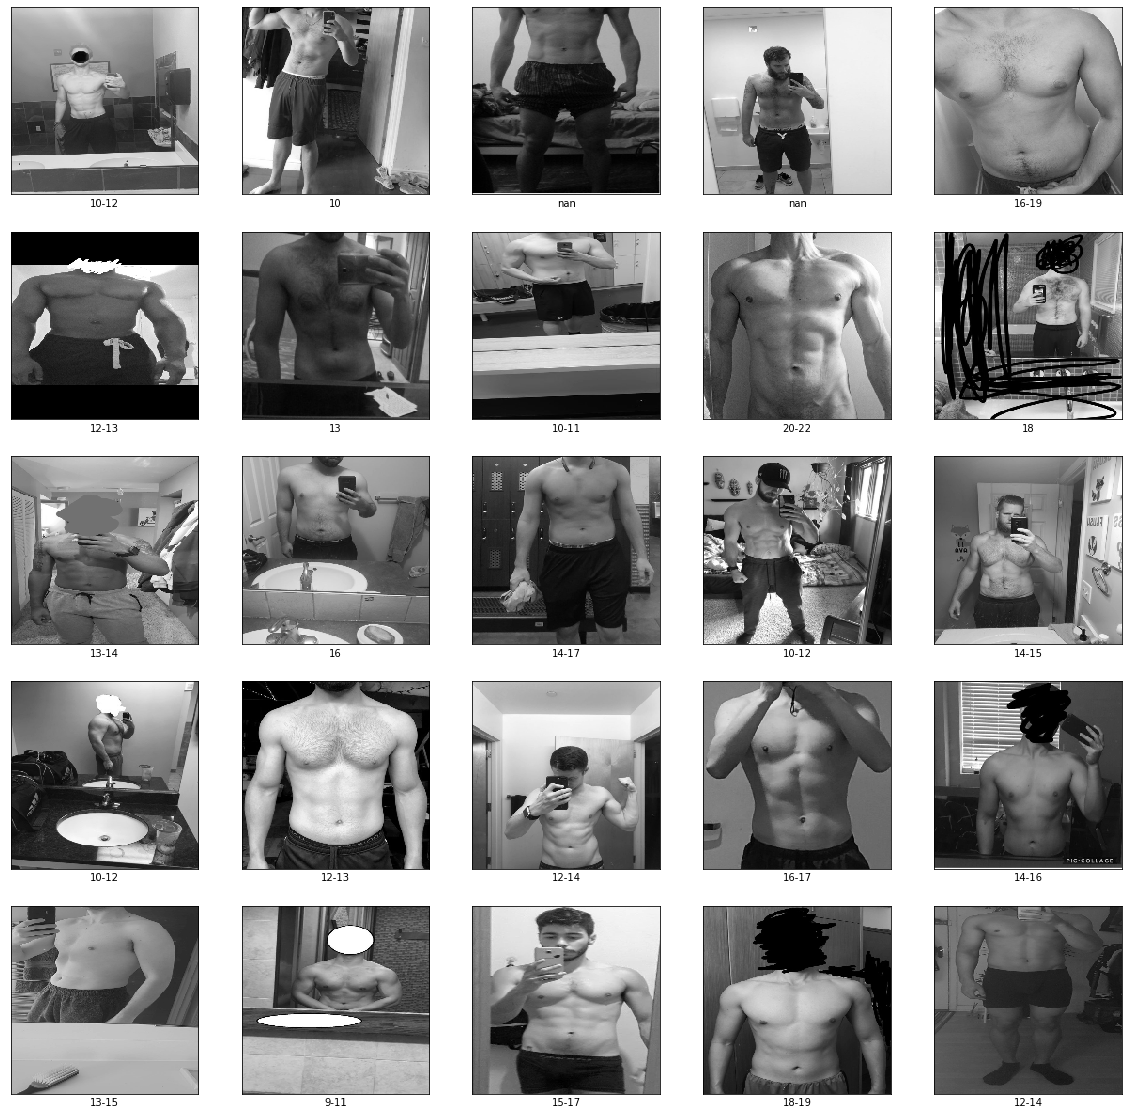

In [0]:
plt.figure(figsize=(20,20))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(images[i], cmap="gray", vmin=0, vmax=255)
  plt.xlabel(df['Bodyfat'][i])
plt.show()

In [0]:
df.dtypes

Gender     object
Age         int64
Weight      int64
Height     object
Bodyfat    object
dtype: object

In [0]:
import pandas_profiling
pandas_profiling.ProfileReport(df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,5
Number of observations,325
Total Missing (%),0.3%
Total size in memory,12.8 KiB
Average record size in memory,40.4 B
Numeric,2
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,1
